# Notebook to take a finetuned sloppy addition model and measure how truth representations within it generalize across contexts

In [1]:
# pick a model
# use the ELK library to train probes on each split (Alice, Bob)
# use the ELK library to get probe predictions to/from both splits, and LM predictions on both splits
# load the Alice/Bob validation datasets and join it with the saved predictions
# make sure this produces "statement" columns that match
# plot AUROC for each probe on each split against each label set with and without ensembling (16 total)

In [1]:
out_dirs = {'bob': {'bob': '/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v1692471371/atmallen/sloppy_addition_bob_1.0/transfer/atmallen/atmallen/sloppy_addition_bob_1.0', 'alice': '/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v1692471371/atmallen/sloppy_addition_bob_1.0/transfer/atmallen/atmallen/sloppy_addition_alice_1.0'}, 'alice': {'alice': '/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v1692471371/atmallen/sloppy_addition_alice_1.0/transfer/atmallen/atmallen/sloppy_addition_alice_1.0', 'bob': '/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v1692471371/atmallen/sloppy_addition_alice_1.0/transfer/atmallen/atmallen/sloppy_addition_bob_1.0'}}

In [9]:
import torch
logprobs = torch.load("/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v1692471371/atmallen/sloppy_addition_alice_1.0/transfer/atmallen/sloppy_addition_alice_1.0" + '/logprobs.pt')

In [11]:
logprobs.keys()

dict_keys(['atmallen/sloppy_addition_alice_1.0'])

In [12]:
raw_logprobs = logprobs['atmallen/sloppy_addition_alice_1.0']
raw_logprobs.keys()

dict_keys(['row_ids', 'texts', 'labels', 'lm', 'lr'])

In [39]:
def get_raw_logprobs(fr: str, to: str, p_err: float):
    logprobs = torch.load(f"/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v1692471371/atmallen/sloppy_addition_{fr}_{p_err}/transfer/atmallen/sloppy_addition_{to}_{p_err}" + '/logprobs.pt')
    return logprobs[f'atmallen/sloppy_addition_{to}_{p_err}']

In [74]:
import numpy as np
import pandas as pd
from typing import Literal
from datasets import load_dataset
from sklearn.metrics import roc_auc_score

NUM_LAYERS = 32

def get_logprobs_df(raw_logprobs: dict, layer: int, ens: Literal["none", "partial"], inlp_iter: int = 0):
    # we need to flatten in the case of "none" ensembling
    row_ids = raw_logprobs["row_ids"].cpu().numpy().reshape(-1)
    texts = np.array(raw_logprobs["texts"]).reshape(-1)
    lm_logprobs = np.array(raw_logprobs["lm"][ens]).reshape(-1)  # same as flatten, sorted by dictionary order where first dimension is most important
    lr_logprobs = np.array(raw_logprobs["lr"][layer][ens][inlp_iter]).reshape(-1)
        
    df = pd.DataFrame({"row_id": row_ids, "text": texts,  "lm": lm_logprobs, "lr": lr_logprobs})
    return df


def measure_auroc_across_layers(raw_logprobs: dict, against: Literal["alice", "bob"], ens: Literal["none", "partial"], inlp_iter: int = 0, p_err: float = 1.0):
    meta = {"against": against, "ens": ens, "inlp_iter": inlp_iter}
    results = []
    both_label_ds = load_dataset(f"atmallen/sloppy_addition_both_labels_{p_err}", split="validation")
    both_label_df = both_label_ds.add_column("row_id", range(len(both_label_ds))).to_pandas()
    for layer in range(NUM_LAYERS):
        layer_df = get_logprobs_df(raw_logprobs, layer, ens, inlp_iter)
        layer_df = layer_df.merge(both_label_df, on="row_id")
        # check that "statement" is a substring of "text" to make sure join is correct
        assert all(layer_df.apply(lambda row: row["statement"] in row["text"], axis=1))
        
        # TODO: add CI
        against_col = f"{against}_label"
        lr_auroc = roc_auc_score(layer_df[against_col], layer_df["lr"])
        lm_auroc = roc_auc_score(layer_df[against_col], layer_df["lm"])

        results.append({"layer": layer, "lr_auroc": lr_auroc, "lm_auroc": lm_auroc, **meta})
        
    results_df = pd.DataFrame(results)
    return results_df

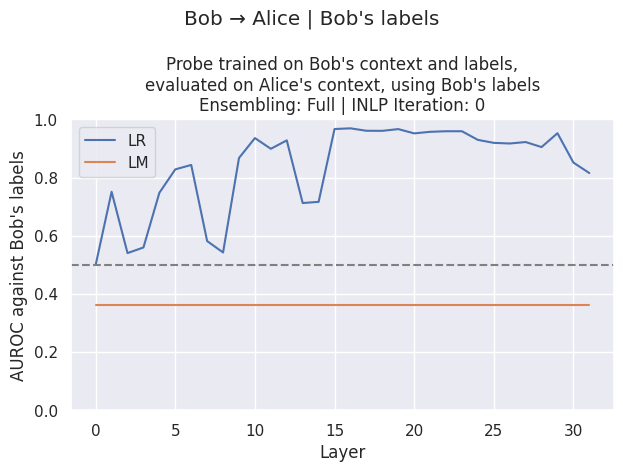

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

fr = "bob"
to = "alice"
against = "bob"
raw_logprobs = get_raw_logprobs(fr, to, p_err=1.0)
ens = "full"
inlp_iter = 0
results_df = measure_auroc_across_layers(raw_logprobs, against, ens, inlp_iter)

# results_df = measure_auroc_across_layers(raw_logprobs, "alice", "none", 0)
sns.lineplot(data=results_df, x="layer", y="lr_auroc", label="LR")
sns.lineplot(data=results_df, x="layer", y="lm_auroc", label="LM")
plt.axhline(y=0.5, color="grey", linestyle="--")

plt.ylim(0, 1.0)

plt.xlabel("Layer")
plt.ylabel(f"AUROC against {against.capitalize()}'s labels")
plt.title(f"Probe trained on {fr.capitalize()}'s context and labels,\nevaluated on {to.capitalize()}'s context, using {against.capitalize()}'s labels\nEnsembling: {ens} | INLP iteration: {inlp_iter}")
plt.suptitle(f"{fr.capitalize()} → {to.capitalize()} | {against.capitalize()}'s labels")
plt.tight_layout()

plt.show()